In [1]:
import sys
import os

# Add the pyquantifier directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from collections import Counter
import numpy as np
from scipy.stats import beta

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.calibration_curve import PlattScaling
from pyquantifier.data import Item, Dataset

# Purpose of this Notebook

I am implementing some alternative calibration curve methods and using this notebook to test them out.

1. Generate a dataset with a known calibration curve (parameterized by logit regression parameters)
2. Subsample to create a calibration sample
3. Fit a calibration curve to the calibration sample using different methods
- Platt scaling
- BinnedCalibrationCurve
- PiecewiseLinearCalibrationCurve
- WeightedPiecewiseLinearCalibrationCurve
4. Evaluate the calibration curves on the full dataset: which come closest to recovering the correct calibration curve and prevalence estimate

## 1 Extrinsic data generator

### 1.1 Generate dataset

In [3]:
def generate_extrinsic_dataset(classifer_score_density_rv, w, b, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    # which pos scores follow the `classifer_score_density` distribution
    all_labels = ["pos", "neg"]
    simulated_pos_scores = classifer_score_density_rv.generate_data(num_base_size)

    calibration_curve = PlattScaling()
    calibration_curve.set_params(w, b)

    items = []
    gt_label_dict = {}
    for idx, pos_score in enumerate(simulated_pos_scores):
        item = Item(
            uid=idx + 1, all_labels=all_labels, all_probs=[pos_score, 1 - pos_score]
        )
        items.append(item)

        calibrated_pos_score = calibration_curve.get_calibrated_prob(pos_score)[0]
        gt_label_dict[item.uid] = np.random.choice(
            all_labels, p=[calibrated_pos_score, 1 - calibrated_pos_score]
        )

    dataset = Dataset(items=items)
    return dataset, gt_label_dict

In [4]:
classifer_score_density_rv = MixtureCUD(
    components=[beta(10, 2), beta(2, 5)], weights=[2, 8]
)
(w, b) = (21.92, -14.61)
num_base_size = 1000000
num_base_size = 10000
num_bin = 10

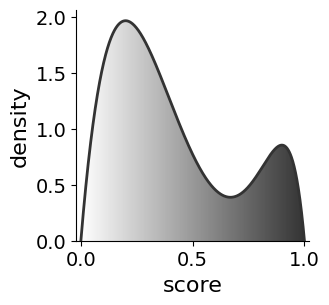

In [5]:
classifer_score_density_rv.plot()

In [6]:
extrinsic_base_dataset, extrinsic_gt_label_dict = generate_extrinsic_dataset(
    classifer_score_density_rv, w, b, num_base_size
)

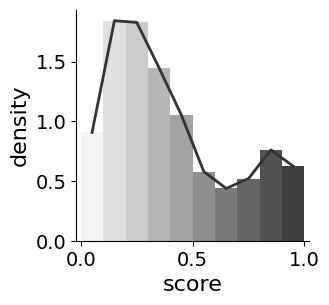

In [7]:
extrinsic_base_dataset.classifier_score_distribution = (
    extrinsic_base_dataset.infer_classifier_score_distribution(num_bin=num_bin)
)
extrinsic_base_dataset.classifier_score_distribution.plot()

In [8]:
# ground truth prevalence
Counter(extrinsic_gt_label_dict.values())["pos"] / num_base_size

0.2057

### 1.2 Subsample calibration sample

In [9]:
num_sample = 1500

original_bin_dict {1: 1843, 2: 1829, 3: 1447, 4: 1051, 0: 907, 8: 761, 9: 624, 5: 579, 7: 521, 6: 438}
to_sample_bin_dict {0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150, 6: 150, 7: 150, 8: 150, 9: 150}


array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

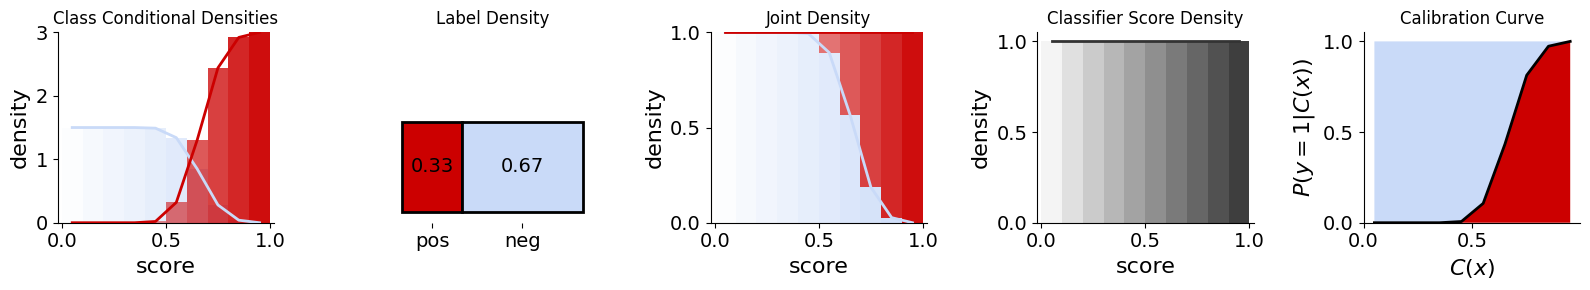

In [10]:
# 2. Select a subset of the dataset and annotate the labels
extrinsic_selected_dataset, extrinsic_selection_weights = (
    extrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample, strategy="uniform", bins=num_bin
    )
)
annotated_labels = [
    extrinsic_gt_label_dict[uid]
    for uid in extrinsic_selected_dataset.df["uid"].values.astype(int)
]
extrinsic_selected_dataset.annotate_sample(annotated_labels)

extrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [11]:
binning_calibration_curve = extrinsic_selected_dataset.calibration_curve

In [12]:
extrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
ps_calibration_curve = extrinsic_selected_dataset.calibration_curve

estimated_w, estimated_b = ps_calibration_curve.get_params()
estimated_w = estimated_w.item()
estimated_b = estimated_b.item()

print(f"True w: {w}, True b: {b}")
print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

True w: 21.92, True b: -14.61
Estimated w: 11.587264011853158, Estimated b: -7.730434740111592


In [13]:
extrinsic_selected_dataset.update_calibration_curve(method="piecewise linear")
piecewise_linear_calibration_curve = extrinsic_selected_dataset.calibration_curve

In [ ]:
extrinsic_selected_dataset.update_calibration_curve(method="adjusted piecewise linear")
adjusted_piecewise_linear_calibration_curve = (
    extrinsic_selected_dataset.calibration_curve
)

ValueError: unsupported calibration method, options are platt scaling, temperature scaling, or nonparametric binning.

### 1.4 Show plots, including Prevalence estimation

#### integrated calibration curve

In [ ]:
extrinsic_base_dataset.extrinsic_estimate(calibration_curve=binning_calibration_curve)

In [ ]:
extrinsic_base_dataset.extrinsic_estimate(calibration_curve=ps_calibration_curve)

## Putting everything together

In [ ]:
def one_bootstrap():
    extrinsic_selected_dataset, extrinsic_selection_weights = (
        extrinsic_base_dataset.select_sample_for_annotation(
            n=num_sample, strategy="uniform", bins=num_bin
        )
    )
    annotated_labels = [
        extrinsic_gt_label_dict[uid]
        for uid in extrinsic_selected_dataset.df["uid"].values.astype(int)
    ]
    extrinsic_selected_dataset.annotate_sample(annotated_labels)
    extrinsic_selected_dataset.update_dataset_model(num_bin=num_bin)

    binning_calibration_curve = extrinsic_selected_dataset.calibration_curve
    binning_integrate_estimate = extrinsic_base_dataset.extrinsic_estimate(
        calibration_curve=binning_calibration_curve
    )

    extrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
    ps_calibration_curve = extrinsic_selected_dataset.calibration_curve
    ps_integrate_estimate = extrinsic_base_dataset.extrinsic_estimate(
        calibration_curve=ps_calibration_curve
    )

    # base_binning_class_conditional_densities = extrinsic_selected_dataset.infer_class_conditional_densities(
    #     num_bin=10,
    #     selection_weights=extrinsic_selection_weights)
    binning_base_jd = ExtrinsicJointDistribution(
        ["pos", "neg"],
        extrinsic_base_dataset.classifier_score_distribution,
        binning_calibration_curve,
    )
    base_binning_class_conditional_densities = (
        binning_base_jd.class_conditional_densities
    )
    binning_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(
        class_conditional_densities=base_binning_class_conditional_densities
    )

    ps_base_jd = ExtrinsicJointDistribution(
        ["pos", "neg"],
        extrinsic_base_dataset.classifier_score_distribution,
        ps_calibration_curve,
    )
    base_ps_class_conditional_densities = ps_base_jd.class_conditional_densities
    ps_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(
        class_conditional_densities=base_ps_class_conditional_densities
    )

    return (
        binning_integrate_estimate,
        ps_integrate_estimate,
        binning_mm_estimate,
        ps_mm_estimate,
    )

In [ ]:
binning_integrate_estimate_list = []
ps_integrate_estimate_list = []
binning_mm_estimate_list = []
ps_mm_estimate_list = []

for idx in range(100):
    (
        binning_integrate_estimate,
        ps_integrate_estimate,
        binning_mm_estimate,
        ps_mm_estimate,
    ) = one_bootstrap()
    binning_integrate_estimate_list.append(binning_integrate_estimate)
    ps_integrate_estimate_list.append(ps_integrate_estimate)
    binning_mm_estimate_list.append(binning_mm_estimate)
    ps_mm_estimate_list.append(ps_mm_estimate)

    print(f"\niteration {idx} done")
    print(f"Binning, integrate {binning_integrate_estimate:.3f}")
    print(f"Platt, integrate {ps_integrate_estimate:.3f}")
    print(f"Binning, MM {binning_mm_estimate:.3f}")
    print(f"Platt, MM {ps_mm_estimate:.3f}")

print(
    f"Binning, integrate {np.mean(binning_integrate_estimate_list):.3f} +- {np.std(binning_integrate_estimate_list):.3f}"
)
print(
    f"Platt, integrate {np.mean(ps_integrate_estimate_list):.3f} +- {np.std(ps_integrate_estimate_list):.3f}"
)
print(
    f"Binning, MM, {np.mean(binning_mm_estimate_list):.3f} +- {np.std(binning_mm_estimate_list):.3f}"
)
print(
    f"Platt, MM, {np.mean(ps_mm_estimate_list):.3f} +- {np.std(ps_mm_estimate_list):.3f}"
)

In [ ]:
base_binning_class_conditional_densities = (
    extrinsic_selected_dataset.infer_class_conditional_densities(
        num_bin=10, selection_weights=extrinsic_selection_weights
    )
)
# binning_base_jd = ExtrinsicJointDistribution(['pos', 'neg'], extrinsic_base_dataset.classifier_score_distribution, binning_calibration_curve)
# base_binning_class_conditional_densities = binning_base_jd.class_conditional_densities
binning_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(
    class_conditional_densities=base_binning_class_conditional_densities
)

ax = base_binning_class_conditional_densities["pos"].plot(return_ax=True, color="red")
base_binning_class_conditional_densities["neg"].plot(ax=ax, color="blue")

print(base_binning_class_conditional_densities["pos"].x_axis)
print(base_binning_class_conditional_densities["pos"].y_axis)
print(base_binning_class_conditional_densities["neg"].x_axis)
print(base_binning_class_conditional_densities["neg"].y_axis)

binning_mm_estimate

In [ ]:
# base_binning_class_conditional_densities = extrinsic_selected_dataset.infer_class_conditional_densities(
#     num_bin=10,
#     selection_weights=extrinsic_selection_weights)
binning_base_jd = ExtrinsicJointDistribution(
    ["pos", "neg"],
    extrinsic_base_dataset.classifier_score_distribution,
    binning_calibration_curve,
)
base_binning_class_conditional_densities = binning_base_jd.class_conditional_densities
binning_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(
    class_conditional_densities=base_binning_class_conditional_densities
)

ax = base_binning_class_conditional_densities["pos"].plot(return_ax=True, color="red")
base_binning_class_conditional_densities["neg"].plot(ax=ax, color="blue")

print(base_binning_class_conditional_densities["pos"].x_axis)
print(base_binning_class_conditional_densities["pos"].y_axis)
print(base_binning_class_conditional_densities["neg"].x_axis)
print(base_binning_class_conditional_densities["neg"].y_axis)

binning_mm_estimate